# <div align="center"><b> Trabajo Final - Visión por computadora 2  - CEIA </b></div>

<div align="right">📝 <em><small><font color='Gray'>Nota:</font></small></em></div>

<div align="right"> <em><small><font color='Gray'> La funcionalidad de visualización de jupyter notebooks en <a href="https://github.com/" target="_blank">github</a> es solamente un preview.</font></small></em> </div>

<div align="right"> <em><small><font color='Gray'> Para mejor visualización se sugiere utilizar el visualizador recomndado por la comunidad: <a href="https://nbviewer.org/" target="_blank">nbviewer</a></font></small></em> </div>

<div align="right"> <em><small><font color='Gray'> Puedes a acceder al sigiente enlace para ver este notebook en dicha página: <a href="https://nbviewer.org/github/brunomaso1/uba-ceia/blob/ceia-nlp/ceia-nlp/Desafio%201.ipynb">Desafio 1</a></font></small></em> </div> 

<!-- TODO: Arreglar el link -->


* * *

<style>
/* Limitar la altura de las celdas de salida en html */
.jp-OutputArea.jp-Cell-outputArea {
    max-height: 500px;
}
</style>

<!-- Colab -->
<!-- <div align="center"><img src="https://drive.google.com/uc?export=view&id=1tUnWeK372o_yu0LxkMwtC4IR2jorDipN" width="600" alt="Figura 1: Detección de palmeras mediante modelos de aprendizaje profundo."></div> -->

<div align="center"><img src="./resources/portada.jpeg" width="600" alt="Figura 1: Detección de palmeras mediante modelos de aprendizaje profundo."></div>

<div align="center"><small><em>Figura 1: Detección de palmeras mediante modelos de aprendizaje profundo.</em></small></div>

<div align="center">✨Datos del proyecto:✨</div>

<p></p>

<div align="center">

| Subtitulo       | Trabajo final - VPC2 - FIUBA                                                                                                           |
| --------------- | -------------------------------------------------------------------------------------------------------------------------------------- |
| **Descrpción**  | Palm tree detector                                                                                                                     |
| **Integrantes** | - Bruno Masoller (brunomaso1@gmail.com) </br> - Simón Rodriguez (simon.andre.r@gmail.com)                                              |

</div>

✋ <em><font color='DodgerBlue'>Importaciones:</font></em> ✋

Inicialmente, cargamos los datos desde Google Drive (si no está disponible el link, se puede desacargar desde Kaggle también -hay información de esto más adelante-):

In [68]:
import os
import warnings

# Definimos la ruta de la carpeta y el archivo de requerimientos
DOWNLOAD_RESOURCES = False # Permite indicar 
CARPETA_RESOURCES = './resources'
RUTA_ARCHIVO_REQUERIMIENTOS = os.path.join(CARPETA_RESOURCES, 'requirements.txt')

# Descargamos la carpeta con archivos auxiliares
if DOWNLOAD_RESOURCES:
    print("Descargando recursos...")
    %pip install gdown
    !gdown https://drive.google.com/drive/folders/1DFfgoGQ8-zLwQU85Uyq0X72GX4IITInV?usp=sharing --folder

# Verificamos si la carpeta ha sido descargada correctamente
if os.path.exists(CARPETA_RESOURCES):
    print(f"La carpeta {CARPETA_RESOURCES} fue encontrada.")

    # Verificamos si el archivo de requerimientos existe
    if os.path.exists(RUTA_ARCHIVO_REQUERIMIENTOS):
        print("Archivo de requerimientos encontrado, instalando dependencias...")
        %pip install -r {archivo_requerimientos}
    else:
        warnings.warn(f"El archivo {RUTA_ARCHIVO_REQUERIMIENTOS} no fue encontrado. No se instalarán los requerimientos.")
else:
    warnings.warn(f"La carpeta {CARPETA_RESOURCES} no fue encontrada. Verifique la descarga.")

La carpeta ./resources fue encontrada.


C:\Users\Ferchita-Maso\AppData\Local\Temp\ipykernel_14832\3988517305.py:24: UserWarning: El archivo ./resources\requirements.txt no fue encontrado. No se instalarán los requerimientos.
  warnings.warn(f"El archivo {RUTA_ARCHIVO_REQUERIMIENTOS} no fue encontrado. No se instalarán los requerimientos.")


In [69]:
import zipfile
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import xml.etree.ElementTree as ET
import cv2
import fiftyone as fo
import shutil
import random

🔧 <em><font color='tomato'>Configuraciones:</font></em> 🔧


In [70]:
# Parámetros
VERBOSE = True # Muestra época a época la evolución
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
RANDOM_SEED = 42

PALMERAS_KAGGLE_DATASET = 'palmeras_kaggle'

RUTA_CARPETA_COMPRESSED = os.path.join(CARPETA_RESOURCES, 'datasets', 'compressed')
RUTA_CARPETA_RAW = os.path.join(CARPETA_RESOURCES, 'datasets', 'raw')
RUTA_CARPETA_KAGGLE_DATASET = os.path.join(RUTA_CARPETA_RAW, PALMERAS_KAGGLE_DATASET)

FORMATOS_IMAGENES = ('.jpg', '.jpeg', '.png')
FORMATOS_LABELS = ('.xml')

random.seed(RANDOM_SEED)

print(f'Dispositivo actual: {DEVICE}')

Dispositivo actual: cpu


## Introduction

En el marco de la especialización en Inteligencia Artificial de la Facultad de Ingeniería de la Universidad de Buenos Aires, se plantea, como trabajo final de la materia Visión por Computadora 2, desarrollar un modelo de visión por computadora que utilice aprendizaje profundo para detectar las ubicaciones de palmeras en diversas imágenes áereas.

Metodológicamente, se aplican principios de [CRISP-ML(Q)](https://ml-ops.org/content/crisp-ml) para el desarrollo del problema.

## Business and data understanding

La detección de palmeras es ampliamente estudiado en el área de visión por computadora, dado su potencial como insumo de otras soluciones, como por ejemplo, aquellas que intentan mejorar la salud de las palmeras, donde inicalmente es deseable una detección aera para luego realizar una inspección manual (con el objetivo de reducir costos).

Muchos estudios (como [este](https://www.researchgate.net/publication/382742087_Implementation_of_Slicing_Aided_Hyper_Inference_SAHI_in_YOLOv8_to_Counting_Oil_Palm_Trees_Using_High-Resolution_Aerial_Imagery_Data) por ejemplo) se realizan en paises en donde la mayoría de las palmeras son materia prima para la producción del "aceite de palmera". Sin embargo, en paises no productores, el cuidado de las palmeras también es importante, dado su impacto en el medio ambiente. 

## Data preparation

Los datos fueron obenidos del sito de Kaggle: https://www.kaggle.com/datasets/riotulab/aerial-images-of-palm-trees, sin embargo, para una mejor manejo, se los importan desde Google Drive (https://drive.google.com/drive/folders/1DFfgoGQ8-zLwQU85Uyq0X72GX4IITInV)

### Data visualization

Luego de descargado los datos, tenemos la siguiente estructura de directorios:

<!-- https://tree.nathanfriend.io/
- resources
  - datasets
    - compressed
      - palmeras_kaggle.zip
 -->

<pre>
resources/
└── datasets/
    └── compressed/
        └── palmeras_kaggle.zip
</pre>

Descomprimimos los datos:

In [71]:
# Crear la carpeta 'raw' si no existe
os.makedirs(RUTA_CARPETA_RAW, exist_ok=True)

# Función para descomprimir archivos .zip
def descomprimir_archivos(carpeta_origen, carpeta_destino):
    archivos = [f for f in os.listdir(carpeta_origen) if f.endswith('.zip')]
    
    if not archivos:
        warnings.warn("No se encontraron archivos .zip para descomprimir.")
        return
    
    for archivo in archivos:
        ruta_archivo = os.path.join(carpeta_origen, archivo)
        print(f"Descomprimiendo {archivo} en {carpeta_destino}...")
        
        # Descomprimir archivo
        with zipfile.ZipFile(ruta_archivo, 'r') as zip_ref:
            zip_ref.extractall(carpeta_destino)
        print(f"{archivo} descomprimido exitosamente.")

# Verificar si la carpeta compressed existe
if os.path.exists(RUTA_CARPETA_COMPRESSED):
    descomprimir_archivos(RUTA_CARPETA_COMPRESSED, RUTA_CARPETA_RAW)
else:
    warnings.warn(f"La carpeta {RUTA_CARPETA_COMPRESSED} no fue encontrada. Verifique la estructura")

Descomprimiendo palmeras.zip en ./resources\datasets\raw...
palmeras.zip descomprimido exitosamente.
Descomprimiendo palmeras_kaggle.zip en ./resources\datasets\raw...
palmeras_kaggle.zip descomprimido exitosamente.


Una vez descomprimido los archivos, podemos observar que el conjunto está en formato PascalVOC (aunque también tiene dos archivos .csv que pueden utilizarse para otros formatos, ej: YOLO).

Ajustamos los archvios para tener una carpeta "data" y otra "labels", de la siguiente forma:

<!--
- Palm-Counting-349images/
  - data/
    - img1.jpg
    - img2.jpg
    - ...
  - labels/
    - img1.xml
    - img2.xml
    - ...
 -->

 <pre>
palmeras_kaggle/
├── data/
│   ├── img1.jpg
│   ├── img2.jpg
│   └── ...
└── labels/
    ├── img1.xml
    ├── img2.xml
    └── ...
 </pre>


In [72]:
# Función para mover archivos a la carpeta correspondiente
def mover_archivos(source_dir, data_dest, label_dest):
    for filename in os.listdir(source_dir):
        file_path = os.path.join(source_dir, filename)
        
        # Verifica si es un archivo de imagen (extensión .jpg o similar)
        if filename.endswith(FORMATOS_IMAGENES):
            shutil.move(file_path, os.path.join(data_dest, filename))
        # Verifica si es un archivo XML
        elif filename.endswith(FORMATOS_LABELS):
            shutil.move(file_path, os.path.join(label_dest, filename))

In [73]:
# Define los paths de las carpetas
base_dir = os.path.join(RUTA_CARPETA_RAW, "Palm-Counting-349images")
train_dir = os.path.join(RUTA_CARPETA_KAGGLE_DATASET, "train")
test_dir = os.path.join(RUTA_CARPETA_KAGGLE_DATASET, "test")

# Renombrar la carpeta Palm-Counting-349images a palmeras_kaggle
if os.path.exists(base_dir):
    if not os.path.exists(RUTA_CARPETA_KAGGLE_DATASET):
        os.rename(base_dir, RUTA_CARPETA_KAGGLE_DATASET)

        # Define los nuevos directorios dentro de la nueva carpeta
        data_dir = os.path.join(RUTA_CARPETA_KAGGLE_DATASET, "data")
        label_dir = os.path.join(RUTA_CARPETA_KAGGLE_DATASET, "labels")

        # Crea las nuevas carpetas si no existen
        os.makedirs(data_dir, exist_ok=True)
        os.makedirs(label_dir, exist_ok=True)

        # Mover archivos de train y test a las nuevas carpetas
        try:
            mover_archivos(train_dir, data_dir, label_dir)
            mover_archivos(test_dir, data_dir, label_dir)
        except:
            warnings.warn(
                f"Error al mover los archivos. Las carpetas {train_dir} y {test_dir} existen? O ya fueron borradas?"
            )

        # Eliminar las carpetas de train y test
        if os.path.exists(train_dir):
            shutil.rmtree(train_dir)
        if os.path.exists(test_dir):
            shutil.rmtree(test_dir)

        # Elimina los archivos .csv
        csv_files = ["train_labels.csv", "test_labels.csv"]
        for csv_file in csv_files:
            csv_path = os.path.join(RUTA_CARPETA_KAGGLE_DATASET, csv_file)
            if os.path.exists(csv_path):
                os.remove(csv_path)

        print(
            "Archivos movidos, archivos CSV eliminados y la carpeta renombrada correctamente."
        )
    else:
        warnings.warn(
            f"Ya existe la ruta {RUTA_CARPETA_KAGGLE_DATASET}, no se hizo nada..."
        )
else:
    warnings.warn(f"No se descomprimió el dataset...")

Archivos movidos, archivos CSV eliminados y la carpeta renombrada correctamente.


Visualizamos la cantidad de imágenes:

In [74]:
# Función para contar archivos .jpg en una carpeta dada
def contar_imagenes(directorio):
    return len([f for f in os.listdir(directorio) if f.endswith(FORMATOS_IMAGENES)])

# Contar imágenes en las carpetas 'test' y 'train'
cant_imagenes = contar_imagenes(os.path.join(RUTA_CARPETA_KAGGLE_DATASET, 'data'))

print(f'Total de imágenes: {cant_imagenes}')

Total de imágenes: 349


Si inspeccionamos algunas imágenes, vemos que tienen un tag `polygon` en el xml. Este tag lo vamos a eliminar para mejor manejo:

In [86]:
# Directorio de etiquetas (carpeta que contiene los archivos XML)
label_dir = os.path.join(RUTA_CARPETA_KAGGLE_DATASET, "labels")

# Función para eliminar los objetos con polygon
def remove_objects_with_polygon(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Encontrar todos los objetos
    for obj in root.findall("object"):
        # Si el objeto tiene un tag polygon, eliminar el objeto
        if obj.find("polygon") is not None:
            root.remove(obj)

    # Guardar los cambios en el archivo
    tree.write(xml_path)

# Recorrer todos los archivos XML en la carpeta de etiquetas
for xml_file in os.listdir(label_dir):
    if xml_file.endswith(".xml"):
        xml_file_path = os.path.join(label_dir, xml_file)
        # Aplicar la función a cada archivo XML
        remove_objects_with_polygon(xml_file_path)
        print(f"Se han eliminado los objetos con polygon de {xml_file_path}")

print("Proceso completado para todos los archivos.")


Se han eliminado los objetos con polygon de ./resources\datasets\raw\palmeras_kaggle\labels\ck2ej1sehu1pn07946turgr8z.xml
Se han eliminado los objetos con polygon de ./resources\datasets\raw\palmeras_kaggle\labels\ck2ek3ke01te607219v2aps5l.xml
Se han eliminado los objetos con polygon de ./resources\datasets\raw\palmeras_kaggle\labels\ck2ekjzk2gp3a0811z41fxk7g.xml
Se han eliminado los objetos con polygon de ./resources\datasets\raw\palmeras_kaggle\labels\ck2el7eirm1p60725d4adv7c3.xml
Se han eliminado los objetos con polygon de ./resources\datasets\raw\palmeras_kaggle\labels\ck2em4wka2twc0721jey85yju.xml
Se han eliminado los objetos con polygon de ./resources\datasets\raw\palmeras_kaggle\labels\ck2enuucruojr0748v1s0syrc.xml
Se han eliminado los objetos con polygon de ./resources\datasets\raw\palmeras_kaggle\labels\ck2epe8qr61g90757vx1kq7gu.xml
Se han eliminado los objetos con polygon de ./resources\datasets\raw\palmeras_kaggle\labels\ck2epp381nyak0725a2dbxnd2.xml
Se han eliminado los obj

Podemos observar una imagen de ejemplo y su detección:

In [87]:
# Función para dibujar los bboxes en una imagen
def draw_pascal_voc_bbox(image_path, annotation_path, ax):
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

    tree = ET.parse(annotation_path)
    root = tree.getroot()

    ax.imshow(image)
    ax.axis("off")  # Deshabilitar los ejes

    for obj in root.findall("object"):
        bbox = obj.find("bndbox")
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)

        # Crear un rectángulo para cada bbox
        rect = patches.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            linewidth=2,
            edgecolor="r",
            facecolor="none",
        )
        ax.add_patch(rect)

        # Mostrar etiqueta
        label = obj.find("name").text
        ax.text(
            xmin, ymin - 10, label, color="white", fontsize=12, backgroundcolor="red"
        )


# Función para dibujar una grilla de imágenes con bboxes
def draw_grid_of_images(image_paths, annotation_paths, grid_size=(3, 3)):
    fig, axs = plt.subplots(grid_size[0], grid_size[1], figsize=(15, 15))

    for i, (image_path, annotation_path) in enumerate(zip(image_paths, annotation_paths)):
        # Llamar a la función original para dibujar los bboxes en cada subgráfico
        draw_pascal_voc_bbox(image_path, annotation_path, axs[i // grid_size[1], i % grid_size[1]])

    # Ajustar el layout para que no se sobrepongan los gráficos
    plt.tight_layout()
    plt.show()


# Función para obtener las rutas de imágenes y anotaciones
def get_image_annotation_paths(image_dir, label_dir, max_files=9):
    # Listar todos los archivos de imágenes (filtrar por extensión de imagen)
    image_files = [f for f in os.listdir(image_dir) if f.endswith(FORMATOS_IMAGENES)]
    # Ordenar los archivos para garantizar el orden
    image_files.sort()

    # Tomar las primeras 'max_files' imágenes
    image_files = image_files[:max_files]

    # Generar las rutas para las imágenes y las anotaciones XML correspondientes
    image_paths = [os.path.join(image_dir, img) for img in image_files]

    # Reemplazar la extensión de la imagen por .xml para encontrar las anotaciones
    annotation_paths = [
        os.path.join(label_dir, os.path.splitext(img)[0] + ".xml")
        for img in image_files
    ]

    return image_paths, annotation_paths

# Función para obtener una imagen y su anotación aleatoria
def get_random_image_and_annotation(image_dir, label_dir):
    # Listar todas las imágenes disponibles en la carpeta
    image_files = [f for f in os.listdir(image_dir) if f.endswith(FORMATOS_IMAGENES)]
    
    # Seleccionar una imagen aleatoria
    random_image = random.choice(image_files)
    
    # Generar las rutas para la imagen y la anotación correspondiente
    image_path = os.path.join(image_dir, random_image)
    annotation_path = os.path.join(label_dir, os.path.splitext(random_image)[0] + ".xml")
    
    return image_path, annotation_path

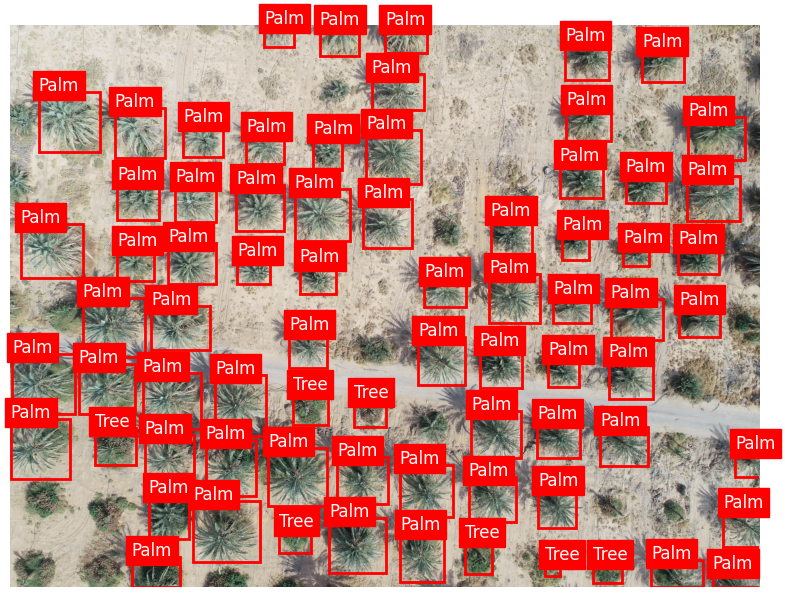

In [88]:
# Directorio de imágenes y anotaciones
image_dir = os.path.join(RUTA_CARPETA_KAGGLE_DATASET, "data")
label_dir = os.path.join(RUTA_CARPETA_KAGGLE_DATASET, "labels")

# Obtener una imagen aleatoria y su correspondiente archivo de anotación
image_path, annotation_path = get_random_image_and_annotation(image_dir, label_dir)

# Dibujar la imagen con sus bboxes
fig, ax = plt.subplots(figsize=(8, 8))
draw_pascal_voc_bbox(image_path, annotation_path, ax)

# Mostrar la imagen con bounding boxes
plt.tight_layout()
plt.show()

También visualizamos varias imágenes:

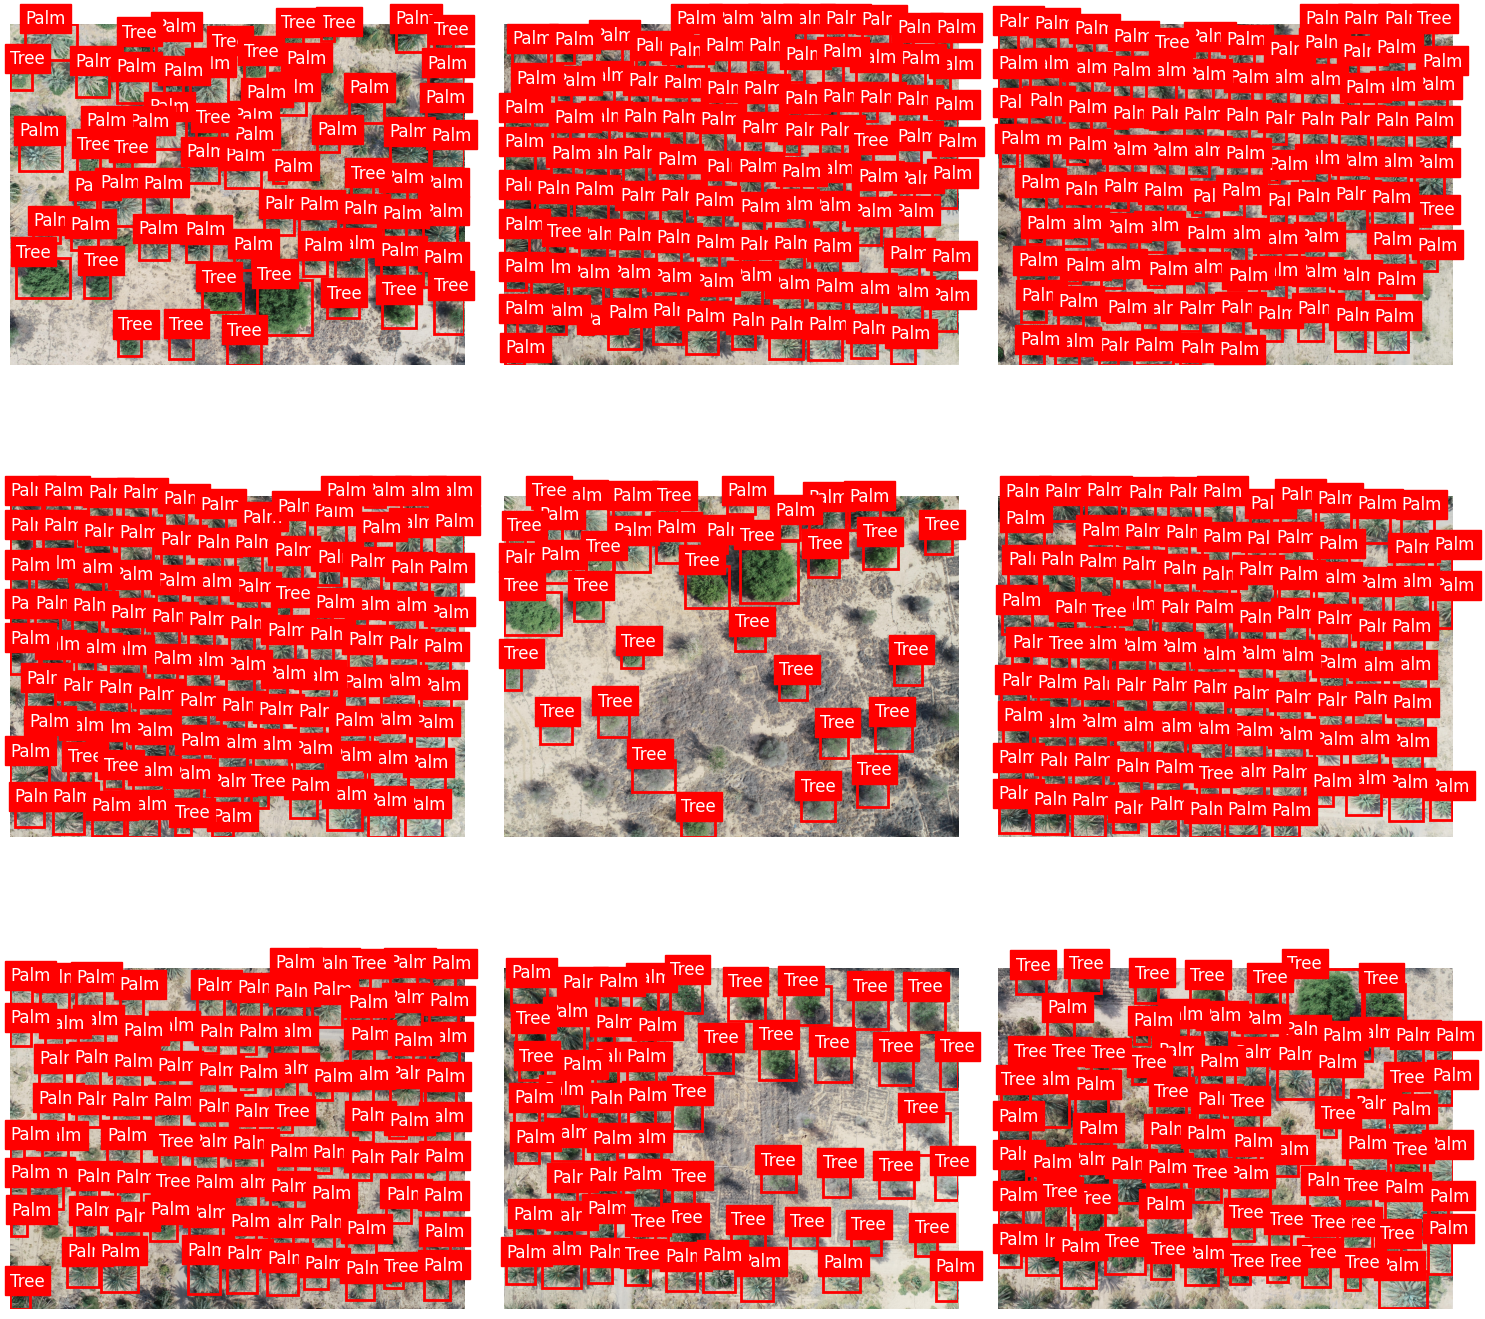

In [89]:
# Directorio de imágenes y anotaciones
image_dir = os.path.join(RUTA_CARPETA_KAGGLE_DATASET, "data")
label_dir = os.path.join(RUTA_CARPETA_KAGGLE_DATASET, "labels")

# Obtener las rutas de las primeras 9 imágenes y anotaciones
image_paths, annotation_paths = get_image_annotation_paths(
    image_dir, label_dir, max_files=9
)

# Llamada a la función para mostrar las imágenes en una grilla de 3x3
draw_grid_of_images(image_paths, annotation_paths, grid_size=(3, 3))

También podemos utilizar la librería de FiftyOne (https://docs.voxel51.com/) para una mejor visualización. Otra ventaja de esta librería es que tiene un módulo de exportación a varios formatos conocidos:

In [95]:
# Crear el dataset en FiftyOne desde un formato PascalVOC
dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.VOCDetectionDataset,
    dataset_dir=RUTA_CARPETA_KAGGLE_DATASET
)

 100% |█████████████████| 349/349 [16.5s elapsed, 0s remaining, 45.8 samples/s]      


Podemos observar los datos del conjunto:

In [96]:
print(dataset)

Name:        2024.10.07.19.37.14
Media type:  image
Num samples: 349
Persistent:  False
Tags:        []
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
    ground_truth:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)



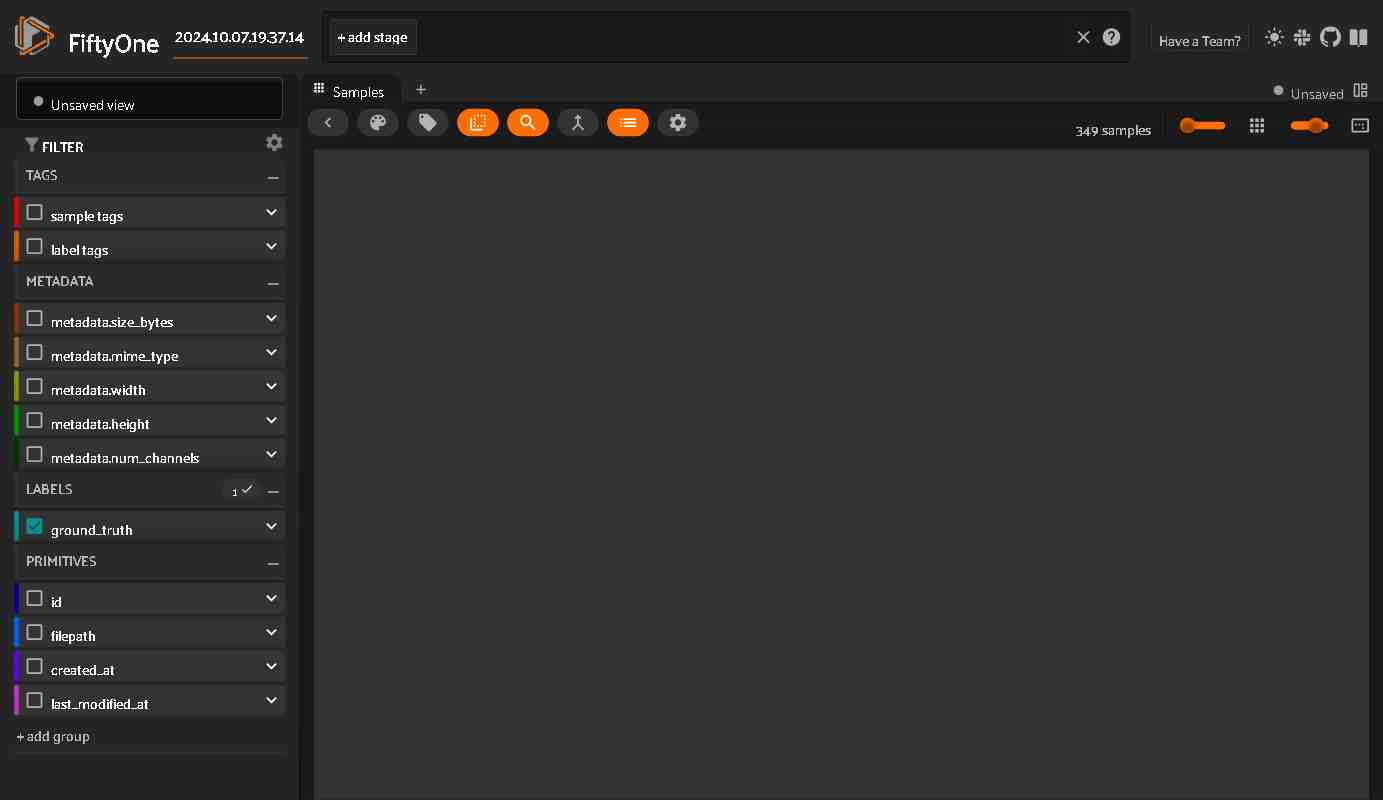

<IPython.core.display.Javascript object>

In [98]:
# Lanzar la aplicación FiftyOne desde Jupyter
session = fo.launch_app(dataset)


session.freeze()
session.open_tab()

## Machine learning model engineering

Como experimentos, dado que inicialmente el modelo no tiene como objetivo el funcionamiento en tiempo real, se plantea utilizar modelos de detección en dos etapas (ej: Faster R-CNN). Sin embargo, también se tienen en cuenta modelos de una sola etapa (ej: YOLO)

### Faster R-CNN

### YOLO

<!-- ## Quality assurance for machine learning applications -->

<!-- ## Deployment -->

<!-- ## Monitoring and maintenance -->

## Referencias

- Adel Ammar, and Anis Koubaa. (2023). Aerial images of palm trees [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DSV/6382990